In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import SRMSE

In [2]:
pums_data_p = pd.read_csv('./data/PUMS_2017_5YR_WA/psam_p53.csv')[['AGEP','JWMNP','SEX','SCHL','COW','DPHY','DEYE','DREM','DOUT','RAC1P']].dropna()
pums_data_h = pd.read_csv('./data/PUMS_2017_5YR_WA/psam_h53.csv')[['HINCP','NP','VEH','BLD','ACCESS']].dropna()
popsim_data_p = pd.read_csv('./populationsim-master/example_wa_16/output/synthetic_persons.csv')[['AGEP','JWMNP','SEX','SCHL','COW','DPHY','DEYE','DREM','DOUT','RAC1P']].dropna()
popsim_data_h = pd.read_csv('./populationsim-master/example_wa_16/output/synthetic_households.csv')[['HINCP','NP','VEH','BLD','ACCESS']].dropna()
vae_data = pd.read_csv('./data/synthetic_populations/wa_persons.csv')[['AGEP','JWMNP','SEX','SCHL','COW','DPHY','DEYE','DREM','DOUT','RAC1P']].dropna()
vae_data_h = pd.read_csv('./data/synthetic_populations/wa_households.csv')[['HINCP','NP','VEH','BLD','ACCESS']].dropna()

In [3]:
SRMSE.calculateSRMSE(popsim_data_p, pums_data_p.sample(len(popsim_data_p), replace=True))
SRMSE.calculateBivariateSRMSE(popsim_data_p, pums_data_p.sample(len(popsim_data_p), replace=True))

Univariate (marginal) SRMSE: 0.07725054092026135
Bivariate (joint) SRMSE: 0.016761879339634904


0.016761879339634904

In [2]:
# Time Tests
num_variables = [4,8,16]
time_vae_train_hh = [51,57,63]
time_vae_gen_hh = [52,48,54]
time_vae_train_p = [134,95,120]
time_vae_gen_p = [129,210,449]
time_vae = []
for i in range(len(num_variables)):
    z = time_vae_train_hh[i]+time_vae_gen_hh[i]+time_vae_train_p[i]+time_vae_gen_p[i]
    time_vae.append(z)
time_pop = [245,588,811]
time_vae

[366, 410, 686]

In [5]:
# Data Tests
num_samples = [10000,1000,100,10,1]
srmse_uni_vae = [.0275,.0391,.0511,.0920,.2022]
srmse_bi_vae = [.0073,.0082,.0123,.0193,.0331]

# Only done with ~100000 samples; using fewer results in errors
srmse_uni_pop = [.0773]
srmse_bi_pop = [.0168]

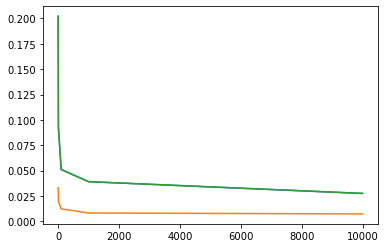

In [10]:
plt.plot(num_samples, srmse_uni_vae)
plt.plot(num_samples, srmse_bi_vae)
plt.plot(num_samples, srmse_uni_vae)

In [13]:
VAR_NAMES_HH = list(pums_data_h.columns)
VAR_NAMES_P = list(pums_data_p.columns)

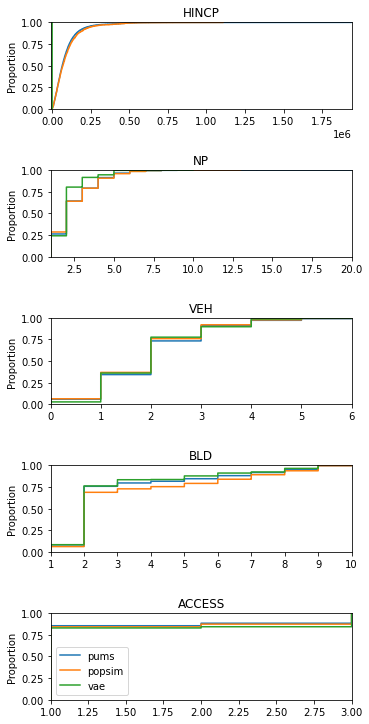

In [14]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES_HH), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(VAR_NAMES_HH):
    sns.ecdfplot(data=pums_data_h, x=var, ax=axes[i]).set(xlim=(min(pums_data_h[var]),max(pums_data_h[var])))
    sns.ecdfplot(data=popsim_data_h, x=var, ax=axes[i]).set(xlim=(min(pums_data_h[var]),max(pums_data_h[var])))
    sns.ecdfplot(data=vae_data_h, x=var, ax=axes[i]).set(xlim=(min(pums_data_h[var]),max(pums_data_h[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)
    plt.legend(labels=['pums','popsim','vae'])